In [1]:
# Preprocessing
import pandas as pd
import tables
from pyproj import Proj, transform
import time
import numpy as np
import gc
from tqdm import tqdm_notebook
from data_processing import get_training_data_2dprojection

In [2]:
#DATA_DIR = '/storage/home/vprov/JUNO/JUNO_students/data/'
TRAIN_DIR = '/srv/hd5/data/vprov/data/phase_1/train/'
tr_lpmt_hits = pd.read_hdf(TRAIN_DIR + 'lpmt_hits.h5', mode='r') 
tr_spmt_hits = pd.read_hdf(TRAIN_DIR + 'spmt_hits.h5', mode='r')
tr_pos = pd.read_csv(TRAIN_DIR + 'pmts_pos.csv') 
#tr_spmt_pos = pd.read_csv(TRAIN_DIR + 'spmt_pos.csv') 
tr_true_info = pd.read_csv(TRAIN_DIR + 'true_info.csv')

In [3]:
def lat(x,y,z):
    return np.arcsin(z/np.sqrt(x**2 + y**2 + z**2))

def lon(x,y,z):
    return np.arctan2(y,x)

In [64]:
tr_true_info['R'].mean()

13297.668783906875

In [4]:
gc.collect()

102

In [5]:
data_lpmt, event_to_id = get_training_data_2dprojection(tr_lpmt_hits, 
                                                        tr_spmt_hits, 
                                                        tr_pos, 
                                                        tr_true_info,
                                                        use_spmt=True)

Make projection
Starting cycle...


In [6]:
#np.save(TRAIN_DIR + 'lpmt_2d_1802', data_lpmt)

In [7]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [8]:
#Training

In [9]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [10]:
#gpu_fraction = 0.1
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [11]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [12]:
tr_true_info['id'] = [event_to_id[evtID] for evtID in tr_true_info['evtID']]

In [13]:
tr_true_info[:3]

,E,R,evtID,x,y,z,id
0,4.747791,14610.378,0,8290.779,11995.6180,911.74286,0
1,3.919721,14630.141,1,11397.632,5407.4497,-7409.08200,1
2,6.823932,14573.132,2,14063.338,-3812.8540,246.65280,2


In [14]:
y_val = tr_true_info[['E', 'R']].values

In [15]:
y_val.shape

(16000, 2)

In [16]:
#y_val = np.load('/srv/hd5/data/vprov/y_val.np.npy')
#data_lpmt = np.load('/srv/hd5/data/vprov/lpmt_proj.np.npy')

In [17]:
data_lpmt = data_lpmt.reshape((*data_lpmt.shape, 1))

In [18]:
import keras
import keras.layers as L
from keras.models import Sequential

Using TensorFlow backend.


In [19]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [20]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18441355764660495414, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7390229300
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7077079662390874639
 physical_device_desc: "device: 0, name: Tesla K40m, pci bus id: 0000:02:00.0, compute capability: 3.5"]

In [21]:
model = Sequential()
model.add(L.Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=256, kernel_size=(3,3),activation='relu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=256, kernel_size=(3,3),activation='relu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=512, kernel_size=(3,3),activation='relu'))
model.add(L.Flatten())
model.add(L.Dense(512, activation='relu'))
model.add(L.Dense(256, activation='relu'))
model.add(L.Dense(128, activation='relu'))
model.add(L.Dense(2))

In [22]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
model.build(input_shape=(None, 151,151,1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 149, 149, 128)     1280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 256)       590080    
__________

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data_lpmt, y_val, test_size=0.3, random_state=45)

In [25]:
X_train.shape, y_train.shape

((11200, 151, 151, 1), (11200, 2))

In [26]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('log_1802.csv', append=True, separator=';')

In [65]:
out = model.fit(X_train, y_train, batch_size=32, 
                epochs=30, 
                callbacks=[csv_logger], 
                validation_data=(X_test, y_test))

Train on 11200 samples, validate on 4800 samples
Epoch 1/30
11200/11200 [==============================] - 67s 6ms/step - loss: 21979.9761 - val_loss: 51647.1999
Epoch 2/30
11200/11200 [==============================] - 67s 6ms/step - loss: 31672.6980 - val_loss: 66217.4665
Epoch 3/30
11200/11200 [==============================] - 67s 6ms/step - loss: 23411.2382 - val_loss: 46844.6041
Epoch 4/30
11200/11200 [==============================] - 67s 6ms/step - loss: 22005.2893 - val_loss: 90550.8440
Epoch 5/30
11200/11200 [==============================] - 67s 6ms/step - loss: 27477.7529 - val_loss: 48605.8543
Epoch 6/30
11200/11200 [==============================] - 66s 6ms/step - loss: 26982.4021 - val_loss: 56377.7809
Epoch 7/30
11200/11200 [==============================] - 67s 6ms/step - loss: 26997.2971 - val_loss: 45880.7516
Epoch 8/30
11200/11200 [==============================] - 67s 6ms/step - loss: 24465.3818 - val_loss: 47569.4728
Epoch 9/30
11200/11200 [=======================

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

In [71]:
cs = pd.read_csv('log_1802.csv', sep=';')

(0, 100000)

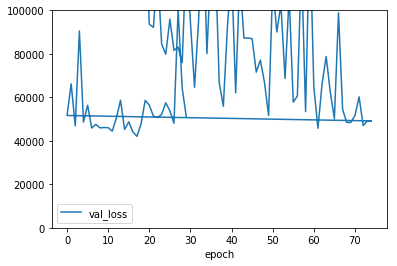

In [72]:
cs.plot(x='epoch',y='val_loss')
plt.ylim((0, 100000))

In [32]:
model.save_weights('18_02_2019all.h5')

In [33]:
with open("model14_02all.json", "w") as json_file:
    json_file.write(model.to_json())

In [34]:
from sklearn.metrics.pairwise import paired_euclidean_distances

In [35]:
from sklearn.metrics import mean_squared_error

In [36]:
# in mm
#test_results = paired_euclidean_distances(model.predict(X_test), y_test)

In [73]:
preds = model.predict(X_test)
test_resultsE = mean_squared_error(np.maximum(preds[:,0], 0), y_test[:,0])
test_resultsR = mean_squared_error(preds[:,1], y_test[:,1])

In [75]:
test_resultsE.mean()

226.6516082621232

In [76]:
test_resultsR.mean()

101617.658293631

In [45]:
test_resultsR.mean() /100000 + test_resultsE.mean() * 100

4829.2580430059115

In [47]:
# Make a submission
TEST_DIR = '/srv/hd5/data/vprov/data/phase_1/test/'
te_lpmt_hits = pd.read_hdf(TEST_DIR + 'test_l_hits.h5', mode='r')
te_spmt_hits = pd.read_hdf(TEST_DIR + 'test_s_hits.h5', mode='r')

In [90]:
len(te_lpmt_hits['event'].unique())

5000

In [48]:
te_data_lpmt, te_event_to_id = get_training_data_2dprojection(te_lpmt_hits, 
                                                              te_spmt_hits, 
                                                              tr_pos, 
                                                              tr_true_info,
                                                              use_spmt=True)

Make projection
Starting cycle...


In [49]:
te_data_lpmt.shape

(5000, 151, 151)

In [50]:
te_data_lpmt = te_data_lpmt.reshape((*te_data_lpmt.shape, 1))

In [51]:
test_answer = model.predict(te_data_lpmt)

In [52]:
test_answer = np.maximum(test_answer, 0)

In [53]:
test_answer[:3]

array([[2.9611804e+00, 1.3507164e+04],
       [1.2070105e+01, 1.5184881e+04],
       [9.2850075e+00, 8.9060557e+03]], dtype=float32)

In [54]:
x = te_lpmt_hits["event"].unique()
pred = pd.DataFrame({
            "evtID": x,
            "R": test_answer[:,1],
            "E": test_answer[:,0]
    })

In [61]:
pred.to_csv('./submissions/18_02sub_Eprev.csv')

In [57]:
previous = pd.read_csv('first_sub.csv')

In [59]:
pred['E'] = previous['E']

In [60]:
pred[:3]

,E,R,evtID
0,0.000000,13507.164062,16000
1,0.758118,15184.880859,16001
2,1.816023,8906.055664,16002


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

(0, 1000)

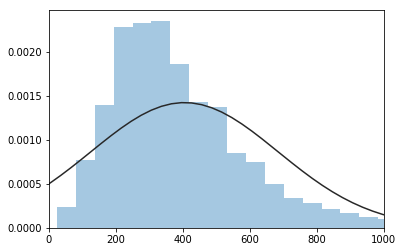

In [48]:
sns.distplot(test_results, kde=False, fit=stats.norm, bins=100)
plt.xlim(0,1000)

In [49]:
test_results.mean()/10

40.478805095559686

In [53]:
results = model.predict(X_test)

In [54]:
xs = results[:,0] - y_test[:,0]

(-1000, 1000)

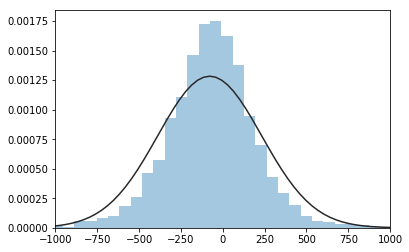

In [57]:
sns.distplot(xs, kde=False, fit=stats.norm, bins=100)
plt.xlim(-1000,1000)

In [59]:
abs(xs).mean()/10

21.422522304369796

In [ ]:
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
## load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")
# 
## evaluate loaded model on test data
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)

In [ ]:
# Adversarial example с нормальным текстом
# Кэширование перевода
# Bert в телефоне